In [ ]:
import sys
import os
from pathlib import Path

# Define paths
if 'AIRFLOW_HOME' in os.environ:
    # Running in Airflow
    BASE_PATH = Path('/opt/airflow')
    DATA_PATH = BASE_PATH / 'data_layer' / 'raw' / 'Resultados'
    SPARK_CONFIG_PATH = BASE_PATH / 'spark_config'
    POSTGRES_HELPER_PATH = BASE_PATH / 'postgres' / 'helpers'
    POSTGRES_PLUGINS_PATH = BASE_PATH / 'postgres' / 'plugins'
else:
    # Running manually
    BASE_PATH = Path.cwd().parent.parent
    DATA_PATH = BASE_PATH / 'data_layer' / 'raw' / 'Resultados'
    SPARK_CONFIG_PATH = BASE_PATH / 'spark_config'
    POSTGRES_HELPER_PATH = BASE_PATH / 'postgres' / 'helpers'
    POSTGRES_PLUGINS_PATH = BASE_PATH / 'postgres' / 'plugins'

# Add paths to system path
sys.path.insert(0, str(SPARK_CONFIG_PATH))
sys.path.insert(0, str(POSTGRES_HELPER_PATH))
sys.path.insert(0, str(POSTGRES_PLUGINS_PATH))

print(f"✅ Base Path: {BASE_PATH}")
print(f"✅ Data Path: {DATA_PATH}")
print(f"✅ Spark Config Path: {SPARK_CONFIG_PATH}")
print(f"✅ Postgres Helper Path: {POSTGRES_HELPER_PATH}")
print(f"✅ Postgres Plugins Path: {POSTGRES_PLUGINS_PATH}")

Base Path: /home/mateus/Documentos/Faculdade/bancos2/TrabalhoSBD2
Data Path: /home/mateus/Documentos/Faculdade/bancos2/TrabalhoSBD2/base_dados/Resultados
Spark Config Path: /home/mateus/Documentos/Faculdade/bancos2/TrabalhoSBD2/spark_config


In [ ]:
# Configurar variáveis de ambiente para conexão PostgreSQL quando rodar manualmente
if 'AIRFLOW_HOME' not in os.environ:
    print("🔧 Configurando variáveis de ambiente para execução manual...")
    
    # Configuração do Data Warehouse (conexão local via Docker)
    os.environ['POSTGRES_DW_DB'] = 'data_warehouse'
    os.environ['POSTGRES_DW_USER'] = 'dw_user'
    os.environ['POSTGRES_DW_PASSWORD'] = 'dw_password'
    os.environ['POSTGRES_HOST'] = 'localhost'  # Fora do Docker usa localhost
    os.environ['POSTGRES_PORT'] = '5433'        # Porta mapeada no docker-compose
    
    print(f"   ✅ Database: {os.environ['POSTGRES_DW_DB']}")
    print(f"   ✅ Host: {os.environ['POSTGRES_HOST']}")
    print(f"   ✅ Port: {os.environ['POSTGRES_PORT']}")
else:
    print("✅ Rodando no Airflow - usando configurações do ambiente Docker")

In [ ]:
from config import SparkConfig, DataSchemas
from pyspark.sql import functions as F

# Create Spark session
spark_config = SparkConfig(app_name="Bronze_Silver_Analysis")
spark = spark_config.create_spark_session()
spark_config.configure_for_banking_data()

print(f"Spark Version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

25/10/17 18:50:39 WARN Utils: Your hostname, mateus-730QED resolves to a loopback address: 127.0.1.1; using 172.20.10.2 instead (on interface wlo1)
25/10/17 18:50:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/17 18:50:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
INFO:config:Spark Session criada: Bronze_Silver_Analysis
INFO:config:Spark UI disponível em: http://172.20.10.2:4040
25/10/17 18:50:45 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:50:45 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v

Spark Version: 3.5.1
Spark UI: http://172.20.10.2:4040


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52146)
Traceback (most recent call last):
  File "/usr/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/home/mateus/Documentos/Faculdade/bancos2/venv-py311/lib/python3.11/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/mateus/Documentos/Faculdade/bancos2/venv-py311/lib/python3.11/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/h

In [3]:
# Load BOP data
bop_file = DATA_PATH / 'BOP.csv'
irfcl_file = DATA_PATH / 'IRFCL.csv'
iip_file = DATA_PATH / 'IIP.csv'
er_file = DATA_PATH / 'ER.csv'
dm_file = DATA_PATH / 'demography.csv'

df_bop = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(bop_file))

df_irfcl = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(irfcl_file))
df_iip = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(iip_file))
df_er = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(er_file))

df_dm = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(dm_file))

print(f"Total records loaded: {df_bop.count():,}")
print(f"Total records loaded: {df_irfcl.count():,}")
print(f"Total records loaded: {df_iip.count():,}")
print(f"Total records loaded: {df_er.count():,}")
print(f"Total records loaded: {df_dm.count():,}")

25/10/17 18:50:55 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:50:55 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:50:55 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:50:57 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:50:57 WARN SQLConf: The 

Total records loaded: 180,804
Total records loaded: 107,805
Total records loaded: 96,247
Total records loaded: 26,418
Total records loaded: 23,072


## Redimencionando BOP

In [4]:
indicadores_nome = {
    # (1) Sinal geral do país
    "CAB": "conta_corrente",
    "CABXEF": "corrente_limpa",
    "KAB": "conta_capital",
    "FAB": "conta_financeira",
    "FABXRRI": "financeira_mercado",
    "EO": "erros_omissões",

    # (2) Componentes do CAB
    "SF": "saldo_comercial",
    "GS": "bens_serviços",
    "IN1": "renda_primária",
    "IN2": "renda_secundária",

    # (3) Composição do financiamento
    "DXEF": "investimento_direto",
    "D_F5": "direto_acoes",
    "D_FL": "direto_divida",
    "PXEF": "portfólio_limpo",
    "P_F5": "portfólio_acoes",
    "P_F3": "portfólio_divida",
    "O_F4": "outros_emprestimos",
    "O_F2": "outros_depositos",
    "O_F81": "credito_comercial",

    # (4) Reservas
    "RUE": "uso_reservas",
    "R_F": "ativos_reservas"
}


accounting_entries = {
    "CD_T": "credito_entrada",
    "DB_T": "debito_saida",
    "NETCD_T": "saldo_liquido",
    "A_NFA_T": "ativos_aquisicao",
    "L_NIL_T": "passivos_incorporacao",
    "NNAFANIL_T": "conta_financeira",
    "A_T": "ativos_total",
    "L_T": "passivos_total"
}


In [5]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# Substitui 0 por nulo
bop_null = df_bop.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))
bop_null = bop_null.withColumnRenamed("UNIT","UNIT_BOP")

# Mapas de nomes amigáveis (se tiver)
indicadores_map = create_map([lit(x) for x in chain(*indicadores_nome.items())])    # Não estou usando no momento
contas_map = create_map([lit(x) for x in chain(*accounting_entries.items())])       # Não estou usando no momento

# Adiciona colunas de nomes e chave para pivot
bop_null = bop_null \
    .withColumn("INDICATOR_NOME", indicadores_map[col("INDICATOR")]) \
    .withColumn("ENTRY_NOME", contas_map[col("BOP_ACCOUNTING_ENTRY")]) \
    .withColumn("pivot_key", concat_ws("/BOP/", col("INDICATOR"), col("BOP_ACCOUNTING_ENTRY")))

# Pivot final
pivoted_BOP = bop_null.groupBy("COUNTRY", "UNIT_BOP", "FREQUENCY", "TIME_PERIOD") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_BOP.show()


25/10/17 18:51:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------+---------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|COUNTRY|UNIT_BOP|FREQUENCY|TIME_PERIOD|     CAB/BOP/NETCD_T|  CABXEF/BOP/NETCD_T|    DXEF/BOP/L_NIL_T|    D_F5/BOP/A_NFA_T|    D_F5/BOP/L_N

In [6]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# 1) Substituir 0 por null e aplicar filtros
dm_null = (
    df_dm
    .withColumn("value", F.when(F.col("value") == 0, F.lit(None)).otherwise(F.col("value")))
    .filter(F.col("SEX").isin("T", "F", "M")) # SEX é ('T', 'M', 'F')
    .filter(F.col("TERRITORIAL_TYPE") == F.lit("TYPO_METRO")) # apenas metropolitano
    .drop("AGE", "SEX", "TERRITORIAL_TYPE") # drop mesmas colunas do Pandas
)

# Adiciona colunas de nomes e chave para pivot
dm_null = dm_null \
    .withColumn("pivot_key", concat_ws("/DM/", col("MEASURE"), col("UNIT_MEASURE")))

# Pivot final
pivoted_DM = dm_null.groupBy('REF_AREA', 'TERRITORIAL_LEVEL','FREQ','TIME_PERIOD') \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_DM.show()

+--------+-----------------+----+-----------+--------------------+----------+----------+-----------+
|REF_AREA|TERRITORIAL_LEVEL|FREQ|TIME_PERIOD|FERT_RATIO/DM/BR_L_W|LFEXP/DM/Y|MORT/DM/DT|  POP/DM/PS|
+--------+-----------------+----+-----------+--------------------+----------+----------+-----------+
|     BRA|             CTRY|   A|       2005|                NULL|      75.8|  582311.0|9.4147106E7|
|     NOR|             CTRY|   A|       2009|                1.98|      83.2|   19912.0|  2395053.0|
|     DNK|             CTRY|   A|       2003|                1.76|      75.0|   28146.0|  2662423.0|
|     NLD|             CTRY|   A|       2020|             1.54489|      83.1|   84361.0|  8759554.0|
|     BEL|             CTRY|   A|       2022|             1.52949|      79.7|   59528.0|  5733645.0|
|     JPN|             CTRY|   A|       2018|                1.42|      87.3|  698300.0|   6.1671E7|
|     AUT|             CTRY|   A|       2004|                1.42|      82.1|   39676.0|  4

In [7]:
# verificação se todas as colunas são diferentes

pivoted_DM_columns = pivoted_DM.columns
if len(pivoted_DM_columns) == len(set(pivoted_DM_columns)):
    print("All columns in pivoted_DM are unique.")

All columns in pivoted_DM are unique.


In [8]:
# opção 1 — orderBy
pivoted_DM.groupBy('REF_AREA', 'TIME_PERIOD').count().orderBy('count', ascending=False).show()

+--------+-----------+-----+
|REF_AREA|TIME_PERIOD|count|
+--------+-----------+-----+
|     ESP|       2011|    1|
|     DEU|       2003|    1|
|     BEL|       2014|    1|
|     CHE|       2016|    1|
|     DEU|       2007|    1|
|     IRL|       2022|    1|
|     KOR|       2010|    1|
|     FRA|       2021|    1|
|     FRA|       2006|    1|
|     USA|       2012|    1|
|     FRA|       2019|    1|
|     CHN|       2001|    1|
|     GBR|       2000|    1|
|     AUT|       2007|    1|
|     CAN|       2020|    1|
|     USA|       2009|    1|
|     POL|       2015|    1|
|     FRA|       2009|    1|
|     RUS|       2001|    1|
|     ITA|       2002|    1|
+--------+-----------+-----+
only showing top 20 rows



In [9]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# 1. Filtrar por tipo de transformação
er_null = df_er.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))

er_null = er_null.filter(col("TYPE_OF_TRANSFORMATION") == "EOP_RT")

# 2. Criar mapa de nomes legíveis (se quiser usar)
indicadores_map = create_map([lit(x) for x in chain(*indicadores_nome.items())])

# 3. Substituir zero por nulo
er_null = er_null.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))
er_null = er_null.withColumnRenamed("TYPE_OF_TRANSFORMATION","TYPE_OF_TRANSFORMATION_ER")


# 4. Criar chave de pivot — pode usar nome legível ou o código
# Se quiser nome legível:
# er_null = er_null.withColumn("INDICATOR_NOME", indicadores_map[col("INDICATOR")])
#          .withColumn("pivot_key", col("INDICATOR_NOME"))

# Se quiser manter como está no código original (com nome técnico):
er_null = er_null.withColumn("pivot_key", concat_ws("/ER/", col("INDICATOR")))

# 5. Aplicar pivot
pivoted_ER = er_null.groupBy("COUNTRY", "TYPE_OF_TRANSFORMATION_ER", "TIME_PERIOD", "FREQUENCY") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_ER.show()


+-------+-------------------------+-----------+---------+------------------+-----------------+------------------+
|COUNTRY|TYPE_OF_TRANSFORMATION_ER|TIME_PERIOD|FREQUENCY|           XDC_EUR|          XDC_USD|           XDC_XDR|
+-------+-------------------------+-----------+---------+------------------+-----------------+------------------+
|    GBR|                   EOP_RT|    2013-Q1|        Q|0.8467795265176558|0.661288189392937|0.9914008932106448|
|    IND|                   EOP_RT|    2006-Q2|        Q|        57.3165605|           45.085| 66.69733891153965|
|    SAU|                   EOP_RT|    2018-Q2|        Q|           4.37175|             3.75| 5.274647372241008|
|    URY|                   EOP_RT|    2021-Q4|        Q|         50.621557|           44.695| 62.55484658352148|
|    CZE|                   EOP_RT|    2005-Q4|        Q|        29.0064636|           24.588| 35.14278363776691|
|    PER|                   EOP_RT|    2021-Q2|        Q|         4.5848472|            

In [10]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# Substitui 0 por nulo
iip_null = df_iip.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))
iip_null = iip_null.withColumnRenamed("UNIT","UNIT_IIP")


# Adiciona colunas de nomes e chave para pivot
iip_null = iip_null \
    .withColumn("pivot_key", concat_ws("/IIP/", col("INDICATOR"), col("BOP_ACCOUNTING_ENTRY")))

# Pivot final
pivoted_IIP = iip_null.groupBy("COUNTRY", "UNIT_IIP", "FREQUENCY", "TIME_PERIOD") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_IIP.show()

+-------+--------+---------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+
|COUNTRY|UNIT_IIP|FREQUENCY|TIME_PERIOD|           D/IIP/A_P|           D/IIP/L_P|        D_F5/IIP/A_P|        D_F5/IIP/L_P|        D_FL/IIP/A_P|        D_FL/IIP/L_P|    NIIP/IIP/NETAL_P|       O_F12/IIP/L_P|     O_F2_NV/IIP/A_P|     O_F2_NV/IIP/L_P|     O_F4_NV/IIP/A_P|     O_F4_NV/IIP/L_P|       O_F81/IIP/A_P|       O_F81/IIP/L_P|       O_FL1/IIP/A_P|     P_F3_MV/IIP/A_P|     P_F3_MV/IIP/

In [11]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# 1. Filtrar por tipo de transformação
irfcl_null = df_irfcl.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))
irfcl_null = irfcl_null.filter(col("SECTOR") == "S1XS1311")
irfcl_null = irfcl_null.withColumnRenamed("SECTOR","SECTOR_IRFCL")

# Se quiser manter como está no código original (com nome técnico):
irfcl_null = irfcl_null.withColumn("pivot_key",  col("INDICATOR"))

# 5. Aplicar pivot
pivoted_IRFCL = irfcl_null.groupBy("COUNTRY", "SECTOR_IRFCL", "TIME_PERIOD", "FREQUENCY") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_IRFCL.show()

+-------+------------+-----------+---------+----------------------------+----------------------------+----------------------------+----------------------------+------------------------------------+----------------------------+-------------------------------+-----------------------------------------+----------------------------------------+-------------------------------------+--------------------------------------+------------------------------------+-------------------------------------+------------------------------------+---------------------------------+----------------------------------------+---------------------------------------+------------------------------------+--------------------+-------------------------------------+-------------------------------------+----------------------------+-----------------------------+-------------------------------+
|COUNTRY|SECTOR_IRFCL|TIME_PERIOD|FREQUENCY|IRFCLDT1_IRFCL32_USD_IRFCL13|IRFCLDT1_IRFCL54_USD_IRFCL13|IRFCLDT1_IRFCL56_USD_IRFCL1

In [12]:
# Exemplo: contar registros por país
count = pivoted_IRFCL.groupBy(["COUNTRY", "TIME_PERIOD"]).count()
# Para ordenar por contagem decrescente:
count_sorted = count.orderBy("count", ascending=False)
count_sorted.show()


+-------+-----------+-----+
|COUNTRY|TIME_PERIOD|count|
+-------+-----------+-----+
|    NLD|    2022-Q2|    1|
|    FRA|    2008-Q3|    1|
|    JPN|    2019-Q2|    1|
|    GBR|    2022-Q1|    1|
|    GBR|    2012-Q2|    1|
|    AUS|    2023-Q4|    1|
|    CHE|    2015-Q2|    1|
|    BEL|    2009-Q2|    1|
|    KOR|    2009-Q3|    1|
|    NOR|    2008-Q4|    1|
|    BRA|    2005-Q1|    1|
|    MEX|    2001-Q3|    1|
|    NOR|    2016-Q4|    1|
|    SGP|    2020-Q2|    1|
|    SGP|    2023-Q4|    1|
|    EGY|    2023-Q4|    1|
|    COL|    2004-Q3|    1|
|    HKG|    2012-Q2|    1|
|    EGY|    2022-Q1|    1|
|    ROU|    2024-Q2|    1|
+-------+-----------+-----+
only showing top 20 rows



In [13]:
linha = pivoted_IRFCL.where((pivoted_IRFCL.COUNTRY == "ESP") & (pivoted_IRFCL.TIME_PERIOD == "2016-Q4"))
# Verifique se há mais de uma linha distinta
if linha.count() > 1:
    # Para cada coluna, veja quais têm valores diferentes entre as linhas
    cols = linha.columns
    vals = linha.collect()
    diffs = []
    for c in cols:
        vset = set([row[c] for row in vals])
        if len(vset) > 1:
            diffs.append(c)
    print(f"Colunas com valores distintos: {diffs}")
else:
    print("Só há uma linha distinta.")
linha = linha.distinct()
linha.show()



Só há uma linha distinta.
+-------+------------+-----------+---------+----------------------------+----------------------------+----------------------------+----------------------------+------------------------------------+----------------------------+-------------------------------+-----------------------------------------+----------------------------------------+-------------------------------------+--------------------------------------+------------------------------------+-------------------------------------+------------------------------------+---------------------------------+----------------------------------------+---------------------------------------+------------------------------------+--------------------+-------------------------------------+-------------------------------------+----------------------------+-----------------------------+-------------------------------+
|COUNTRY|SECTOR_IRFCL|TIME_PERIOD|FREQUENCY|IRFCLDT1_IRFCL32_USD_IRFCL13|IRFCLDT1_IRFCL54_USD_IRFCL13|I

In [14]:
columns_bop = set(pivoted_BOP.columns)
columns_iip = set(pivoted_IIP.columns)
columns_er = set(pivoted_ER.columns)
columns_irfcl = set(pivoted_IRFCL.columns)

intersecao = columns_bop & columns_iip & columns_er & columns_irfcl
print(f"Colunas em comum entre todos os dataframes: {intersecao}")


Colunas em comum entre todos os dataframes: {'TIME_PERIOD', 'COUNTRY', 'FREQUENCY'}


In [15]:
# Primeiro join: BOP com ER
merged_df = pivoted_BOP.join(
    pivoted_ER,
    on=['TIME_PERIOD', 'FREQUENCY', 'COUNTRY'],
    how="outer"
)

# Segundo join: resultado anterior com IIP
merged_df = merged_df.join(
    pivoted_IIP,
    on=['TIME_PERIOD', 'FREQUENCY', 'COUNTRY'],
    how="outer"
)

# Terceiro join: resultado anterior com IRFCL
merged_df = merged_df.join(
    pivoted_IRFCL,
    on=['TIME_PERIOD', 'FREQUENCY', 'COUNTRY'],
    how="outer"
)

merged_df.show()

+-----------+---------+-------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------------+------------------+-----------------+------------------+--------+--------------------+--------------------+---------

In [16]:
import pyspark.sql.functions as F

pivoted_DM = pivoted_DM.withColumnRenamed("REF_AREA", "COUNTRY")

# padronize o período: ano em ambos, por exemplo
a = merged_df.withColumn("YEAR", F.split("TIME_PERIOD", "-").getItem(0).cast("int"))
b = pivoted_DM.withColumn("YEAR", F.col("TIME_PERIOD").cast("int")).drop("TIME_PERIOD")

# agora use on=["COUNTRY", "YEAR"] para o join
final_df = a.join(b, on=["COUNTRY", "YEAR"], how="left")
# -> só 1 coluna COUNTRY e 1 coluna YEAR no resultado

merged_df = final_df.drop("YEAR")
merged_df.show()

+-------+-----------+---------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------------+------------------+-----------------+------------------+--------+--------------------+--------------------+---------

In [17]:
print(merged_df.count())
print(len(merged_df.columns))

5603
106


In [18]:
merged_df.dtypes

[('COUNTRY', 'string'),
 ('TIME_PERIOD', 'string'),
 ('FREQUENCY', 'string'),
 ('UNIT_BOP', 'string'),
 ('CAB/BOP/NETCD_T', 'double'),
 ('CABXEF/BOP/NETCD_T', 'double'),
 ('DXEF/BOP/L_NIL_T', 'double'),
 ('D_F5/BOP/A_NFA_T', 'double'),
 ('D_F5/BOP/L_NIL_T', 'double'),
 ('D_FL/BOP/A_NFA_T', 'double'),
 ('D_FL/BOP/L_NIL_T', 'double'),
 ('EO/BOP/NETCD_T', 'double'),
 ('FAB/BOP/NNAFANIL_T', 'double'),
 ('FABXRRI/BOP/NNAFANIL_T', 'double'),
 ('GS/BOP/CD_T', 'double'),
 ('GS/BOP/DB_T', 'double'),
 ('GS/BOP/NETCD_T', 'double'),
 ('IN1/BOP/CD_T', 'double'),
 ('IN1/BOP/DB_T', 'double'),
 ('IN1/BOP/NETCD_T', 'double'),
 ('IN2/BOP/CD_T', 'double'),
 ('IN2/BOP/DB_T', 'double'),
 ('IN2/BOP/NETCD_T', 'double'),
 ('KAB/BOP/NETCD_T', 'double'),
 ('O_F2/BOP/A_NFA_T', 'double'),
 ('O_F2/BOP/L_NIL_T', 'double'),
 ('O_F2/BOP/NNAFANIL_T', 'double'),
 ('O_F4/BOP/A_NFA_T', 'double'),
 ('O_F4/BOP/L_NIL_T', 'double'),
 ('O_F4/BOP/NNAFANIL_T', 'double'),
 ('O_F81/BOP/A_NFA_T', 'double'),
 ('O_F81/BOP/L_NIL_T', 

In [19]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

# Colunas-chave (ajuste se necessário)
KEY_COLS = ["COUNTRY", "TIME_PERIOD"]

# 1) Detectar todas as colunas numéricas (excluindo chaves e datas)
num_cols = [
    f.name for f in merged_df.schema.fields
    if isinstance(f.dataType, NumericType) and f.name not in KEY_COLS
]
print(f"[INFO] Foram detectadas {len(num_cols)} colunas numéricas.")

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)
INFO:matplotlib.font_manager:generated new fontManager


[INFO] Foram detectadas 97 colunas numéricas.


In [20]:
def _box_stats_for_metric(sdf, colname, rel_tol=1e-6):
    """
    Calcula estatísticas de boxplot (Tukey) no Spark e retorna
    um dict compatível com matplotlib.pyplot.bxp.
    """
    # Quantis aproximados (rápidos e escaláveis)
    q = sdf.approxQuantile(colname, [0.25, 0.5, 0.75], rel_tol)
    # Se a coluna for toda nula/vazia, devolve box vazio seguro
    if q is None or len(q) != 3:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    q1, med, q3 = q
    if q1 is None or q3 is None:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    # Limitar whiskers ao min/max dos pontos dentro do intervalo [low, high]
    inside = sdf.select(F.col(colname).alias("v")).where(
        F.col("v").isNotNull() & (F.col("v") >= low) & (F.col("v") <= high)
    )

    # Se não houver pontos "inside", caia para min/max gerais (evita erro)
    if inside.rdd.isEmpty():
        bounds = sdf.select(F.min(colname).alias("lo"), F.max(colname).alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi
    else:
        bounds = inside.select(F.min("v").alias("lo"), F.max("v").alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi

    return dict(med=med, q1=q1, q3=q3, whislo=lo, whishi=hi, fliers=[])

In [21]:
def _box_stats_for_metric(sdf, colname, rel_tol=1e-6, max_fliers=500):
    """
    Calcula estatísticas de boxplot (Tukey) no Spark e retorna
    um dict compatível com Axes.bxp, agora com 'fliers' preenchido.
    """
    q = sdf.approxQuantile(colname, [0.25, 0.5, 0.75], rel_tol)
    if not q or len(q) != 3:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    q1, med, q3 = q
    if q1 is None or q3 is None:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    inside = sdf.select(F.col(colname).alias("v")).where(
        F.col("v").isNotNull() & (F.col("v") >= low) & (F.col("v") <= high)
    )

    if inside.rdd.isEmpty():
        bounds = sdf.select(F.min(colname).alias("lo"), F.max(colname).alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi
    else:
        bounds = inside.select(F.min("v").alias("lo"), F.max("v").alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi

    # ---- calcular outliers (fliers) ----
    fliers_df = sdf.select(F.col(colname).alias("v")).where(
        F.col("v").isNotNull() & ((F.col("v") < low) | (F.col("v") > high))
    )
    # limite de segurança para não trazer milhões de pontos
    fliers_vals = (
        fliers_df
        .limit(max_fliers)              # cap opcional
        .rdd.map(lambda r: float(r[0])) # lista de floats
        .collect()
    )

    return dict(med=med, q1=q1, q3=q3, whislo=lo, whishi=hi, fliers=fliers_vals)


In [22]:
import numpy as np

def _sample_values(sdf, colname, max_points=1000, frac=None):
    q = sdf.select(F.col(colname).alias("v")).where(F.col("v").isNotNull())
    if frac is not None:
        q = q.sample(withReplacement=False, fraction=frac, seed=42)
    return q.limit(max_points).rdd.map(lambda r: float(r[0])).collect()



def plot_boxplots_by_country(sdf, country, metrics=None, max_metrics=5, rel_tol=1e-6, title_suffix="ANTES"):
    """
    Plota boxplots para TODAS (ou um subconjunto) das colunas numéricas de um país.
    - sdf: DataFrame Spark (ex.: merged_df)
    - country: string (ex.: "BRA")
    - metrics: lista de colunas numéricas (default: todas detectadas)
    - max_metrics: limite para não poluir o gráfico
    - rel_tol: tolerância do approxQuantile
    - title_suffix: texto no título ("ANTES", "DEPOIS", etc.)
    """
    if metrics is None:
        metrics = num_cols
    metrics = metrics[:max_metrics]

    # Recorte por país e remover linhas totalmente nulas nas colunas analisadas
    base = sdf.filter(F.col("COUNTRY") == country)
    # (opcional) se quiser garantir que haja valores: base = base.na.drop(subset=metrics)

    # Calcula as stats no Spark e traz só os números
    stats = [_box_stats_for_metric(base, m, rel_tol=rel_tol) for m in metrics]

    # Caso alguma métrica não tenha dados, substitui por um box "vazio" (evita erro do bxp)
    cleaned_stats = []
    cleaned_labels = []
    for m, s in zip(metrics, stats):
        if None in (s["q1"], s["q3"], s["med"], s["whislo"], s["whishi"]):
            # pula métricas sem dados válidos
            continue
        cleaned_stats.append(s)
        cleaned_labels.append(m)

    if not cleaned_stats:
        print(f"[WARN] Sem dados numéricos válidos para {country} nas métricas selecionadas.")
        return


    fig_w = max(8, len(cleaned_stats)*0.9)
    fig, ax = plt.subplots(figsize=(fig_w, 6))

    # usar o método do eixo em vez de plt.bxp
    ax.bxp(cleaned_stats, showfliers=True)

    # Depois do ax.bxp(...):
    for i, m in enumerate(cleaned_labels, start=1):
        vals = _sample_values(base, m, max_points=800)  # coleta amostra
        if not vals: 
            continue
        x = np.random.normal(loc=i, scale=0.04, size=len(vals))  # jitter ao redor da x=i
        ax.scatter(x, vals, alpha=0.35, s=10)  # pontos de todos os valores (amostrados)

    ax.set_xticks(range(1, len(cleaned_labels) + 1))
    ax.set_xticklabels(cleaned_labels, rotation=45, ha="right")
    ax.set_title(f"Boxplots ({title_suffix}) — {country}")

    fig.tight_layout()
    plt.show()




25/10/17 18:51:54 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:51:57 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:52:04 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:52:08 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:52:10 WARN SQLConf: The 

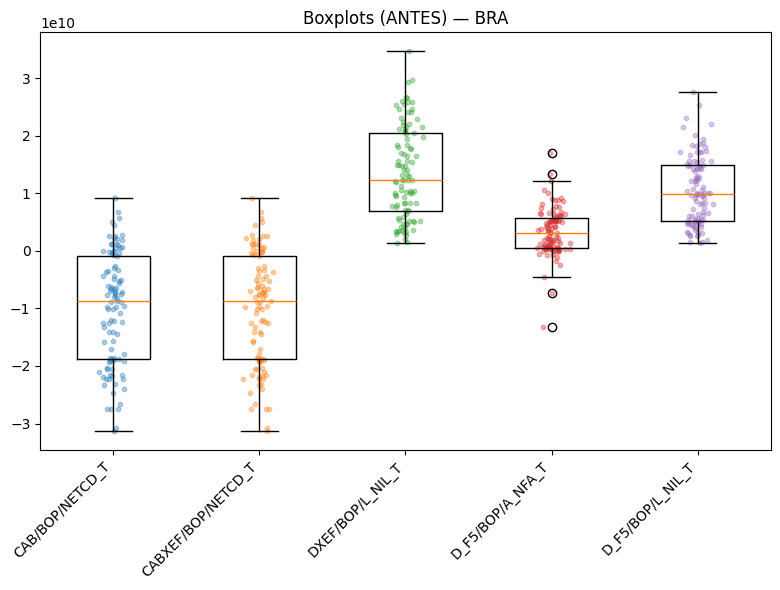

In [23]:

plot_boxplots_by_country(merged_df, country="BRA", title_suffix="ANTES")


In [24]:
from pyspark.sql import functions as F

def build_iqr_thresholds(sdf, group_cols=["COUNTRY"], metrics=None, accuracy=200, whisker=1.5):
    """
    Calcula Q1/Q3/IQR/low/high por grupo (ex.: por COUNTRY) para várias métricas,
    usando percentile_approx (agregador nativo do Spark).
    Retorna um DF com colunas: group_cols + para cada métrica: __q1, __q3, __iqr, __low, __high.
    """
    if metrics is None:
        # use sua lista já detectada de numéricas
        metrics = [f.name for f in sdf.schema.fields if isinstance(f.dataType, NumericType) and f.name not in ["COUNTRY","TIME_PERIOD"]]

    # agrega Q1 e Q3 por grupo
    agg_exprs = []
    for c in metrics:
        agg_exprs += [
            F.expr(f"percentile_approx({c}, 0.25, {accuracy})").alias(f"{c}__q1"),
            F.expr(f"percentile_approx({c}, 0.75, {accuracy})").alias(f"{c}__q3"),
        ]

    th = sdf.groupBy(*group_cols).agg(*agg_exprs)

    # calcula IQR e limites, com guardas para casos degenerados (iqr nulo/zero)
    for c in metrics:
        q1 = F.col(f"{c}__q1")
        q3 = F.col(f"{c}__q3")
        iqr = (q3 - q1)
        th = th.withColumn(f"{c}__iqr", iqr) \
               .withColumn(
                   f"{c}__low",
                   F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q1 - whisker * iqr)
               ).withColumn(
                   f"{c}__high",
                   F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q3 + whisker * iqr)
               )
    return th


In [25]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

def build_iqr_thresholds(sdf, group_cols=["COUNTRY"], metrics=None, accuracy=200, whisker=1.5):
    """
    Calcula Q1/Q3/IQR/low/high por grupo para várias métricas
    usando percentile_approx em API de coluna (seguro p/ nomes com caracteres especiais).
    """
    if metrics is None:
        metrics = [
            f.name for f in sdf.schema.fields
            if isinstance(f.dataType, NumericType) and f.name not in ["COUNTRY","TIME_PERIOD"]
        ]

    # agrega Q1 e Q3 por grupo usando a API de coluna
    agg_exprs = []
    for c in metrics:
        agg_exprs += [
            F.percentile_approx(F.col(c), 0.25, accuracy).alias(f"{c}__q1"),
            F.percentile_approx(F.col(c), 0.75, accuracy).alias(f"{c}__q3"),
        ]

    th = sdf.groupBy(*group_cols).agg(*agg_exprs)

    # calcula IQR e limites com guardas
    for c in metrics:
        q1 = F.col(f"{c}__q1")
        q3 = F.col(f"{c}__q3")
        iqr = (q3 - q1)
        th = (
            th.withColumn(f"{c}__iqr", iqr)
              .withColumn(
                  f"{c}__low",
                  F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q1 - whisker * iqr)
              )
              .withColumn(
                  f"{c}__high",
                  F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q3 + whisker * iqr)
              )
        )
    return th


In [26]:
from pyspark.sql.types import NumericType

def nullify_outliers_all(sdf, group_cols=["COUNTRY"], metrics=None, whisker=1.5, accuracy=200):
    """
    Substitui por NULL os outliers (v < low ou v > high) em TODAS as métricas,
    por grupo (ex.: por COUNTRY). Mantém valores dentro do intervalo e nulos originais.
    """
    if metrics is None:
        metrics = [f.name for f in sdf.schema.fields if isinstance(f.dataType, NumericType) and f.name not in ["COUNTRY","TIME_PERIOD"]]

    # calcula limiares e faz join
    th = build_iqr_thresholds(sdf, group_cols, metrics, accuracy=accuracy, whisker=whisker)
    df = sdf.join(th, on=group_cols, how="left")

    # aplica nulificação por métrica
    out = df
    schema_map = {f.name: f.dataType for f in sdf.schema.fields}  # para cast de NULL seguro
    for c in metrics:
        lo = F.col(f"{c}__low")
        hi = F.col(f"{c}__high")
        # se low/high indisponíveis (IQR==0 ou quantis nulos), não mexe na coluna
        out = out.withColumn(
            c,
            F.when(lo.isNull() | hi.isNull(), F.col(c)) \
             .when(F.col(c).isNull(), F.col(c)) \
             .when((F.col(c) < lo) | (F.col(c) > hi), F.lit(None).cast(schema_map[c])) \
             .otherwise(F.col(c))
        )

    # remove colunas auxiliares
    aux_cols = [col for col in out.columns if col.endswith(("__q1","__q3","__iqr","__low","__high"))]
    return out.drop(*aux_cols)


In [27]:
# nulificar outliers por país (todas as métricas numéricas)
clean_df = nullify_outliers_all(merged_df, group_cols=["COUNTRY"], whisker=1.5, accuracy=200)

# opcional: verificar quantos valores viraram NULL em uma métrica
m = "DXEF/BOP/L_NIL_T"  # exemplo
before_nulls = merged_df.where(F.col(m).isNull()).count()
after_nulls  = clean_df.where(F.col(m).isNull()).count()
print(f"{m}: nulos antes={before_nulls}, depois={after_nulls}, inseridos={after_nulls - before_nulls}")


DXEF/BOP/L_NIL_T: nulos antes=801, depois=1060, inseridos=259


In [28]:
# Exemplo: contar registros por país
count = clean_df.groupBy(["COUNTRY", "TIME_PERIOD"]).count()
# Para ordenar por contagem decrescente:
count_sorted = count.orderBy("count", ascending=False)
count_sorted.show()


+-------+-----------+-----+
|COUNTRY|TIME_PERIOD|count|
+-------+-----------+-----+
|    SGP|    2000-Q1|    1|
|    IDN|    2001-Q3|    1|
|    MEX|    2001-Q3|    1|
|    HUN|    2004-Q1|    1|
|    COL|    2004-Q3|    1|
|    BRA|    2005-Q1|    1|
|    NOR|    2007-Q4|    1|
|    GHA|    2008-Q2|    1|
|    FRA|    2008-Q3|    1|
|    NOR|    2008-Q4|    1|
|    BEL|    2009-Q2|    1|
|    KOR|    2009-Q3|    1|
|    GHA|    2011-Q1|    1|
|    KWT|    2011-Q3|    1|
|    CHN|    2012-Q2|    1|
|    GBR|    2012-Q2|    1|
|    HKG|    2012-Q2|    1|
|    KEN|    2014-Q2|    1|
|    CHE|    2015-Q2|    1|
|    NOR|    2016-Q4|    1|
+-------+-----------+-----+
only showing top 20 rows



In [29]:
linha = clean_df.where((clean_df.COUNTRY == "ESP") & (clean_df.TIME_PERIOD == "2016-Q4"))
# Verifique se há mais de uma linha distinta
if linha.count() > 1:
    # Para cada coluna, veja quais têm valores diferentes entre as linhas
    cols = linha.columns
    vals = linha.collect()
    diffs = []
    for c in cols:
        vset = set([row[c] for row in vals])
        if len(vset) > 1:
            diffs.append(c)
    print(f"Colunas com valores distintos: {diffs}")
else:
    print("Só há uma linha distinta.")
linha = linha.distinct()
linha.show()



Só há uma linha distinta.


25/10/17 18:57:00 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB


+-------+-----------+---------+--------+-------------------+-------------------+-----------------+-----------------+-------------------+-----------------+--------------------+-----------------+------------------+----------------------+--------------------+--------------------+-----------------+---------------+-------------------+---------------+-----------------+-------------------+-----------------+-----------------+-----------------+-----------------+--------------------+----------------+-----------------+-------------------+-------------------+-----------------+--------------------+----------------+-----------------+-----------------+-----------------+-----------------+-------------------+-------------+--------------+----------------+-----------------+-------------------------+-------+-------+-------+--------+--------------+--------------+-------------+--------------+--------------+--------------+----------------+-------------+---------------+---------------+---------------+--------

25/10/17 18:57:07 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:57:13 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:57:24 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:57:31 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/17 18:57:36 WARN SQLConf: The 

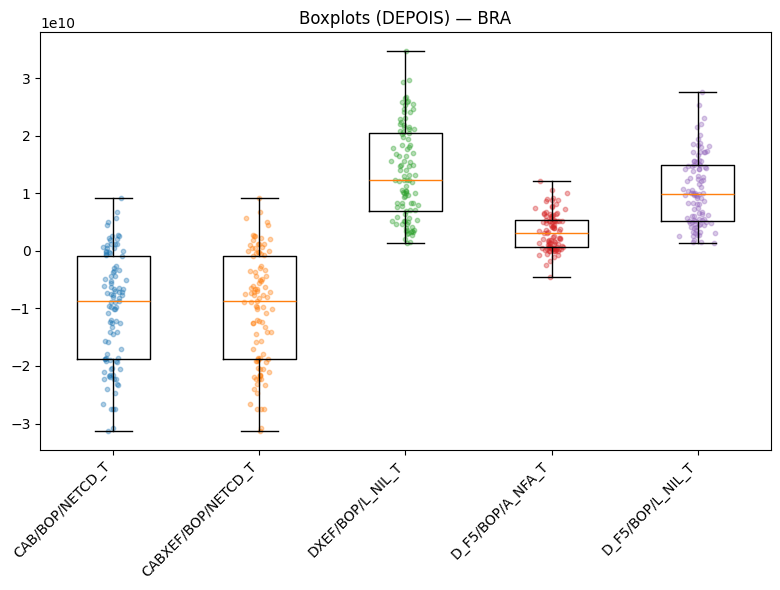

In [30]:
plot_boxplots_by_country(clean_df, country="BRA", title_suffix="DEPOIS")


In [ ]:
# --- imports necessários ---
import math
from typing import Iterable, Dict, Any, List

from postgres_helper import get_postgres_conn
from cliente_postgres import ClientPostgresDB

# Se precisar:
# from pyspark.sql import functions as F
# from pyspark.sql import DataFrame as SparkDataFrame

def _sanitize_column_name(name: str) -> str:
    """
    Saneia nomes de coluna para PostgreSQL sem aspas:
    - minúsculas
    - troca qualquer caractere não [a-z0-9_] por "_"
    - comprime repetições de "_" e remove "_" nas pontas
    """
    import re
    s = name.lower()
    s = re.sub(r"[^a-z0-9_]+", "_", s)
    s = re.sub(r"_{2,}", "_", s)
    s = s.strip("_")
    return s or "col"

def sanitize_columns_spark(df, reserved: List[str] = None):
    """
    Renomeia todas as colunas do Spark DF de modo seguro p/ Postgres (sem aspas).
    Mantém 'country' e 'time_period' se existirem (ou converte pra minúsculas).
    """
    reserved = set(reserved or [])
    renames = {}
    for c in df.columns:
        new_c = _sanitize_column_name(c)
        if c.lower() in {"country", "time_period"}:
            new_c = c.lower()
        # evita colisão: se já existe, anexa índice
        base = new_c
        i = 2
        while new_c in renames.values():
            new_c = f"{base}_{i}"
            i += 1
        renames[c] = new_c

    out = df
    for old, new in renames.items():
        if old != new:
            out = out.withColumnRenamed(old, new)
    return out, renames

def _row_to_dict(row) -> Dict[str, Any]:
    """
    Converte Spark Row -> dict "puro" (recursivo).
    """
    d = row.asDict(recursive=True)
    # Converte numpy types, Decimal etc. para tipos Python padrão quando necessário
    try:
        import numpy as np
        for k, v in list(d.items()):
            if isinstance(v, np.generic):
                d[k] = v.item()
    except Exception:
        pass
    return d

def write_spark_to_postgres_in_batches(
    sdf,
    table_name: str,
    schema: str = "silver",  # ✅ Schema correto
    conflict_fields: List[str] = None,  # ex.: ["country","time_period"]
    primary_key: List[str] = None,      # ex.: ["country","time_period"]
    batch_size: int = 10_000,
    sanitize_columns: bool = True,
    conn_id: str = "postgres_dw",  # 🔥 NOVO: usar conexão do Data Warehouse
) -> None:
    """
    Envia um Spark DF ao Postgres chamando ClientPostgresDB.insert_data() em lotes.

    - Sem toPandas (usa toLocalIterator)
    - Cria a tabela automaticamente (via insert_data -> create_table_if_not_exists)
    - Pode fazer UPSERT se conflict_fields for fornecido
    
    🔥 IMPORTANTE: Usa conn_id="postgres_dw" para salvar no Data Warehouse!
    
    Schemas disponíveis no data_warehouse: staging, bronze, silver, gold
    """
    # 1) Colunas: sanitizar (recomendado se você tem nomes com "/", espaços, etc.)
    sdf_out = sdf
    rename_map = {}
    if sanitize_columns:
        sdf_out, rename_map = sanitize_columns_spark(sdf_out)

    # 2) Conexão - 🔥 USANDO A CONEXÃO CORRETA DO DATA WAREHOUSE
    conn_str = get_postgres_conn(conn_id=conn_id)
    client = ClientPostgresDB(conn_str)
    
    print(f"[INFO] Conectando ao banco via conn_id='{conn_id}'")
    print(f"[INFO] Salvando em schema='{schema}', tabela='{table_name}'")

    # 3) Iterar em lotes
    batch: List[Dict[str, Any]] = []
    count = 0

    for row in sdf_out.toLocalIterator():  # stream sem explodir memória
        batch.append(_row_to_dict(row))
        if len(batch) >= batch_size:
            client.insert_data(
                data=batch,
                table_name=table_name,
                conflict_fields=conflict_fields,
                primary_key=primary_key,
                schema=schema,
            )
            count += len(batch)
            batch.clear()

    if batch:
        client.insert_data(
            data=batch,
            table_name=table_name,
            conflict_fields=conflict_fields,
            primary_key=primary_key,
            schema=schema,
        )
        count += len(batch)

    print(f"[OK] Inseridos {count} registros em {schema}.{table_name}")
    if rename_map:
        print("[INFO] Renomeações aplicadas (Spark -> Postgres):")
        for k, v in rename_map.items():
            if k != v:
                print(f"  - {k} -> {v}")


ModuleNotFoundError: No module named 'postgres_helper'

In [ ]:
# 🔥 Exemplo de chamada - USANDO CONEXÃO CORRETA DO DATA WAREHOUSE
write_spark_to_postgres_in_batches(
    clean_df,
    table_name="bop_clean",                     # nome da tabela
    schema="silver",                            # ✅ schema correto
    conflict_fields=["country","time_period"],  # para UPSERT
    primary_key=["country","time_period"],      # cria PK se a tabela for nova
    batch_size=10_000,
    sanitize_columns=True,                      # recomendado se tiver nomes com "/"
    conn_id="postgres_dw",                      # 🔥 CORRIGIDO: usar Data Warehouse!
)
